In [1]:
import pandas as pd
import numpy as np

In [2]:
test_features = pd.read_csv("test_features.csv", index_col = 0)
training_features = pd.read_csv("training_features.csv", index_col = 0)

In [8]:
test_feat_fill = test_features.copy()
test_feat_fill = test_feat_fill.replace([np.inf, -np.inf], np.nan)
test_feat_fill =test_feat_fill.fillna(test_feat_fill.mean())

In [3]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [4]:
from keras import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import optimizers

Using TensorFlow backend.


In [93]:
class Model:
    def __init__(self, train_set, test_set):
        self.train_set = train_set
        self.test_set = test_set
        
        X = train_set.iloc[:,1:]
        y = train_set.iloc[:,0].map(lambda x: 1 if x == True else 0 )
        
        self.X = X
        self.y = y
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.33, random_state=33)
        
        
    def Random_Forest(self):
        rf_model = RandomForestClassifier(n_estimators=300, 
                                  max_depth=10,
                                  random_state=100,
                                    max_features=0.5,
                                    min_samples_leaf=5)
        
        cv_results = cross_validate(rf_model, self.X_train, self.y_train, cv=3,
                            scoring= 'roc_auc',
                            return_train_score=True,
                            return_estimator =True)
        
        rf_model.fit(self.X_train, self.y_train)
        
        importance = pd.Series(rf_model.feature_importances_, index=self.X_train.columns)
        self.rf_importance = importance.sort_values()[-15:] # show top 15
        
        return rf_model.predict_proba(self.test_set)[:,1]
    
    def LGB(self):
        bst = lgb.LGBMClassifier(boosting_type= 'gbdt',
                        objective = 'binary',
                        max_depth = 3,
                        n_estimators = 1000)

        bst.fit(self.X_train.values, self.y_train.values)
        
        importance = pd.Series(bst.feature_importances_, index=self.X_train.columns)
        self.GBM_importance = importance.sort_values()[-15:] # show top 15
        
        return bst.predict_proba(self.test_set)[:,1]
    
    def Neural_Net(self):
        scaler = StandardScaler()
        scaler.fit(self.X)
        
        X_scale = scaler.transform(self.X)
        y_array = self.y.values
        
        X_train, X_test_s, y_train, y_test = train_test_split(X_scale, y_array, test_size=0.33, random_state=33)
        X_train_mlp, X_validation, y_train_mlp, y_validation = train_test_split(X_train, y_train, test_size=0.15, random_state=33)
        
        model = Sequential()

        #First Hidden Layer
        model.add(Dense(128, activation='relu', kernel_initializer='random_normal', input_dim=X_train.shape[1]))

        #Second  Hidden Layer
        model.add(Dense(64, activation='relu', kernel_initializer='random_normal'))    
        
        #Output Layer
        model.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        # add early stop to prevent overfitting
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)
        mc = ModelCheckpoint('best_model2.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

        history = model.fit(X_train, y_train,
                            validation_split = 0.15,
                            epochs=4000, verbose=0, callbacks=[es, mc])

        saved_model = load_model('best_model2.h5')
        
        #scale test data
        scaler.fit(self.test_set)
        X_test_scale = scaler.transform(self.test_set)
        
        NN_predict = saved_model.predict_proba(X_test_scale)
        nn_prob = np.array([ x[0] for x in NN_predict])
        
        self.weights, self.biases = saved_model.layers[0].get_weights()
        
        return nn_prob
    
    def predict(self):
        rf_predictions = self.Random_Forest()
        lgb_predictions = self.LGB()
        #nn_predictions = self.Neural_Net()
        
        self.predictions = pd.DataFrame({'LGB':lgb_predictions,
                                         'Random Forest':rf_predictions,
                                         #'Neural Net':nn_predictions
                                          }, 
                                          index = self.test_set.index)

        #self.predictions['Model Average'] = self.predictions.mean(axis = 1)
        self.predictions['RF+LGB'] = (self.predictions['LGB']+self.predictions['Random Forest'])/2
        
        return self.predictions

In [10]:
%%time
validationModel = Model(train_set=training_features, test_set=test_feat_fill)
validation_predictions = validationModel.predict()

Wall time: 34.8 s


In [19]:
validation_predictions.sort_values(by = 'RF+LGB', ascending=True)

,LGB,Random Forest,Neural Net,Model Average,RF+LGB
ID14418595663,0.035543,0.123444,0.063834,0.074274,0.079494
ID81074761078,0.006994,0.153889,0.055672,0.072185,0.080441
ID3319752171,0.024825,0.139513,0.045771,0.070037,0.082169
ID53643609794,0.027072,0.145263,0.041580,0.071305,0.086168
ID97320350211,0.035183,0.137399,0.058470,0.077017,0.086291
...,...,...,...,...,...
ID12868925050,0.998368,0.985650,0.999051,0.994357,0.992009
ID38824705704,0.999978,0.984996,0.999652,0.994875,0.992487
ID67268564816,0.995868,0.989807,0.975502,0.987059,0.992837
ID22368291682,0.998056,0.990010,0.943936,0.977334,0.994033


In [167]:
validation_predictions[validation_predictions['RF+LGB'] > .586].sort_values(by = 'RF+LGB', ascending=True)

,LGB,Random Forest,Neural Net,Model Average,RF+LGB
ID4467853207,0.612034,0.560352,0.607801,0.593396,0.586193
ID28083356250,0.576103,0.598152,0.600523,0.591593,0.587128
ID9509203773,0.645885,0.528644,0.338518,0.504349,0.587265
ID30186003507,0.621164,0.553760,0.610121,0.595015,0.587462
ID43865646209,0.478468,0.696751,0.554165,0.576461,0.587609
...,...,...,...,...,...
ID12868925050,0.998368,0.985650,0.999051,0.994357,0.992009
ID38824705704,0.999978,0.984996,0.999652,0.994875,0.992487
ID67268564816,0.995868,0.989807,0.975502,0.987059,0.992837
ID22368291682,0.998056,0.990010,0.943936,0.977334,0.994033


In [168]:
patient1 = test_feat_fill[test_feat_fill.index == 'ID38179240346']
patient2 = test_feat_fill[test_feat_fill.index == 'ID14418595663']
patient3 = test_feat_fill[test_feat_fill.index == 'ID4467853207']

In [23]:
patient1

,MME_on_day0,SUPPLY_CNT_on_day0,PAYABLE_QTY_on_day0,max_MME_prior,avg_MME_prior,total_SUPPLY_CNT_prior,total_PAYABLE_QTY_prior,opioid_cost_on_day_0,opioid_net_payment_on_day_0,supply_times,...,generic_pc0,generic_pc1,generic_pc2,generic_pc3,generic_pc4,generic_pc5,generic_pc6,generic_pc7,generic_pc8,generic_pc9
ID38179240346,60.0,30.0,60.0,60.0,49.375,960.0,2020.0,37.1,33.8,34,...,-11.479123,-1.085007,-2.815576,-2.672498,-1.605798,0.311737,-0.794862,-2.69832,0.092048,0.151319


In [24]:
patient1.columns

Index(['MME_on_day0', 'SUPPLY_CNT_on_day0', 'PAYABLE_QTY_on_day0',
       'max_MME_prior', 'avg_MME_prior', 'total_SUPPLY_CNT_prior',
       'total_PAYABLE_QTY_prior', 'opioid_cost_on_day_0',
       'opioid_net_payment_on_day_0', 'supply_times', 'total_costs_on_day_0',
       'total_net_payment_on_day_0', 'net_payment_portion_on_day_0',
       'opioid_cost_portion_on_day_0', 'MME_times_SUPPLY_day_0',
       'total_cost_divide_SUPPLY_day_0', 'total_net_payment_divide_on_day_0',
       'np_portion_divide_SUPPLY_day_0', 'oc_portion_divide_SUPPLY_day_0',
       'max_MME_prior_divide_SUPPLY_day_0',
       'avg_MME_prior_divide_SUPPLY_day_0', 'tsc_prior_divide_SUPPLY_day_0',
       'tpa_prior_divide_SUPPLY_day_0', 'oc_day_0_divide_SUPPLY_day_0',
       'np_day_0_divide_SUPPLY_day_0', 'generic_pc0', 'generic_pc1',
       'generic_pc2', 'generic_pc3', 'generic_pc4', 'generic_pc5',
       'generic_pc6', 'generic_pc7', 'generic_pc8', 'generic_pc9'],
      dtype='object')

In [30]:
patient1['MME_on_day0'].values[0]

60.0

In [51]:
patient1.T.ID38179240346

MME_on_day0                            60.000000
SUPPLY_CNT_on_day0                     30.000000
PAYABLE_QTY_on_day0                    60.000000
max_MME_prior                          60.000000
avg_MME_prior                          49.375000
total_SUPPLY_CNT_prior                960.000000
total_PAYABLE_QTY_prior              2020.000000
opioid_cost_on_day_0                   37.100000
opioid_net_payment_on_day_0            33.800000
supply_times                           34.000000
total_costs_on_day_0                   45.470000
total_net_payment_on_day_0             40.850000
net_payment_portion_on_day_0            0.898395
opioid_cost_portion_on_day_0            0.815923
MME_times_SUPPLY_day_0               1800.000000
total_cost_divide_SUPPLY_day_0          1.515667
total_net_payment_divide_on_day_0       1.361667
np_portion_divide_SUPPLY_day_0          0.029946
oc_portion_divide_SUPPLY_day_0          0.027197
max_MME_prior_divide_SUPPLY_day_0       2.000000
avg_MME_prior_divide

In [46]:
def change_inital(patient_features, new_SC_0):
    old_SC_0 = patient_features['SUPPLY_CNT_on_day0'].values[0]
    
    mult_factor = new_SC_0/old_SC_0
    divide_factor = old_SC_0/new_SC_0
    
    mme = patient_features[['MME_on_day0']]
    
    sc = patient_features[['SUPPLY_CNT_on_day0']]*(mult_factor)
    
    initials = patient_features[['PAYABLE_QTY_on_day0',
       'max_MME_prior', 'avg_MME_prior', 'total_SUPPLY_CNT_prior',
       'total_PAYABLE_QTY_prior', 'opioid_cost_on_day_0',
       'opioid_net_payment_on_day_0', 'supply_times', 'total_costs_on_day_0',
       'total_net_payment_on_day_0', 'net_payment_portion_on_day_0',
       'opioid_cost_portion_on_day_0']]
    
    mme_sc = patient_features[['MME_times_SUPPLY_day_0']]*(mult_factor)
    
    divide = patient_features[['total_cost_divide_SUPPLY_day_0', 'total_net_payment_divide_on_day_0',
       'np_portion_divide_SUPPLY_day_0', 'oc_portion_divide_SUPPLY_day_0',
       'max_MME_prior_divide_SUPPLY_day_0',
       'avg_MME_prior_divide_SUPPLY_day_0', 'tsc_prior_divide_SUPPLY_day_0',
       'tpa_prior_divide_SUPPLY_day_0', 'oc_day_0_divide_SUPPLY_day_0',
       'np_day_0_divide_SUPPLY_day_0']]*(divide_factor)
    
    pcs = patient_features[['generic_pc0', 'generic_pc1',
       'generic_pc2', 'generic_pc3', 'generic_pc4', 'generic_pc5',
       'generic_pc6', 'generic_pc7', 'generic_pc8', 'generic_pc9']]
    
    concat = pd.concat([mme, sc, initials, mme_sc, divide, pcs], axis = 1)
    
    return concat

In [54]:
change_inital(patient1, 15).T

,ID38179240346
MME_on_day0,60.000000
SUPPLY_CNT_on_day0,15.000000
PAYABLE_QTY_on_day0,60.000000
max_MME_prior,60.000000
avg_MME_prior,49.375000
total_SUPPLY_CNT_prior,960.000000
total_PAYABLE_QTY_prior,2020.000000
opioid_cost_on_day_0,37.100000
opioid_net_payment_on_day_0,33.800000
supply_times,34.000000


## Make a range for each patient

In [118]:
patient1_options = []

for supply_count in range(15, 91):
    df = change_inital(patient1, supply_count)
    patient1_options.append(df)
    
patient1_options = pd.concat(patient1_options)

In [119]:
len(patient1_options)

76

In [80]:
#patient1_options.index = range(16)

In [120]:
patient1_options

,MME_on_day0,SUPPLY_CNT_on_day0,PAYABLE_QTY_on_day0,max_MME_prior,avg_MME_prior,total_SUPPLY_CNT_prior,total_PAYABLE_QTY_prior,opioid_cost_on_day_0,opioid_net_payment_on_day_0,supply_times,...,generic_pc0,generic_pc1,generic_pc2,generic_pc3,generic_pc4,generic_pc5,generic_pc6,generic_pc7,generic_pc8,generic_pc9
ID38179240346,60.0,15.0,60.0,60.0,49.375,960.0,2020.0,37.1,33.8,34,...,-11.479123,-1.085007,-2.815576,-2.672498,-1.605798,0.311737,-0.794862,-2.69832,0.092048,0.151319
ID38179240346,60.0,16.0,60.0,60.0,49.375,960.0,2020.0,37.1,33.8,34,...,-11.479123,-1.085007,-2.815576,-2.672498,-1.605798,0.311737,-0.794862,-2.69832,0.092048,0.151319
ID38179240346,60.0,17.0,60.0,60.0,49.375,960.0,2020.0,37.1,33.8,34,...,-11.479123,-1.085007,-2.815576,-2.672498,-1.605798,0.311737,-0.794862,-2.69832,0.092048,0.151319
ID38179240346,60.0,18.0,60.0,60.0,49.375,960.0,2020.0,37.1,33.8,34,...,-11.479123,-1.085007,-2.815576,-2.672498,-1.605798,0.311737,-0.794862,-2.69832,0.092048,0.151319
ID38179240346,60.0,19.0,60.0,60.0,49.375,960.0,2020.0,37.1,33.8,34,...,-11.479123,-1.085007,-2.815576,-2.672498,-1.605798,0.311737,-0.794862,-2.69832,0.092048,0.151319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID38179240346,60.0,86.0,60.0,60.0,49.375,960.0,2020.0,37.1,33.8,34,...,-11.479123,-1.085007,-2.815576,-2.672498,-1.605798,0.311737,-0.794862,-2.69832,0.092048,0.151319
ID38179240346,60.0,87.0,60.0,60.0,49.375,960.0,2020.0,37.1,33.8,34,...,-11.479123,-1.085007,-2.815576,-2.672498,-1.605798,0.311737,-0.794862,-2.69832,0.092048,0.151319
ID38179240346,60.0,88.0,60.0,60.0,49.375,960.0,2020.0,37.1,33.8,34,...,-11.479123,-1.085007,-2.815576,-2.672498,-1.605798,0.311737,-0.794862,-2.69832,0.092048,0.151319
ID38179240346,60.0,89.0,60.0,60.0,49.375,960.0,2020.0,37.1,33.8,34,...,-11.479123,-1.085007,-2.815576,-2.672498,-1.605798,0.311737,-0.794862,-2.69832,0.092048,0.151319


In [121]:
pd.concat([test_feat_fill, patient1_options])

,MME_on_day0,SUPPLY_CNT_on_day0,PAYABLE_QTY_on_day0,max_MME_prior,avg_MME_prior,total_SUPPLY_CNT_prior,total_PAYABLE_QTY_prior,opioid_cost_on_day_0,opioid_net_payment_on_day_0,supply_times,...,generic_pc0,generic_pc1,generic_pc2,generic_pc3,generic_pc4,generic_pc5,generic_pc6,generic_pc7,generic_pc8,generic_pc9
ID10006701904,15.0,60.0,180.0,15.000,15.000000,180.0,540.0,12.99,10.04,4,...,48.350820,0.060177,0.142896,0.057026,0.024847,0.000939,0.002131,0.009115,0.026106,-0.071860
ID10020514442,5.0,15.0,15.0,30.000,25.000000,17.0,88.0,2.95,0.00,3,...,-12.230161,-7.231021,10.118839,1.342367,0.122096,0.045913,-0.120080,-0.555012,-0.046686,0.002618
ID10025902702,20.0,10.0,40.0,0.000,0.000000,0.0,0.0,6.20,0.00,1,...,-11.962103,-5.205734,5.832193,0.047956,-0.417183,0.122288,-0.308651,-1.175410,-0.051055,0.005571
ID10028172382,10.0,90.0,180.0,45.000,18.544118,344.0,714.0,11.03,0.00,18,...,78.239224,0.667846,1.584893,1.355973,0.785141,-0.136111,0.346092,1.221776,0.069056,-0.113528
ID10034724702,30.0,30.0,120.0,28.125,28.125000,4.0,15.0,23.80,0.00,2,...,-11.992713,-1.792174,-4.876461,-6.180492,-5.899266,-16.881587,17.209279,13.213839,-0.013770,-0.007309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID38179240346,60.0,86.0,60.0,60.000,49.375000,960.0,2020.0,37.10,33.80,34,...,-11.479123,-1.085007,-2.815576,-2.672498,-1.605798,0.311737,-0.794862,-2.698320,0.092048,0.151319
ID38179240346,60.0,87.0,60.0,60.000,49.375000,960.0,2020.0,37.10,33.80,34,...,-11.479123,-1.085007,-2.815576,-2.672498,-1.605798,0.311737,-0.794862,-2.698320,0.092048,0.151319
ID38179240346,60.0,88.0,60.0,60.000,49.375000,960.0,2020.0,37.10,33.80,34,...,-11.479123,-1.085007,-2.815576,-2.672498,-1.605798,0.311737,-0.794862,-2.698320,0.092048,0.151319
ID38179240346,60.0,89.0,60.0,60.000,49.375000,960.0,2020.0,37.10,33.80,34,...,-11.479123,-1.085007,-2.815576,-2.672498,-1.605798,0.311737,-0.794862,-2.698320,0.092048,0.151319


In [122]:
%%time
new_model = Model(train_set=training_features, test_set=pd.concat([test_feat_fill, patient1_options]))
new_predictions = new_model.predict()

Wall time: 25.3 s


In [125]:
new_predictions.iloc[-len(patient1_options):]

,LGB,Random Forest,RF+LGB
ID38179240346,0.838195,0.783124,0.810659
ID38179240346,0.884910,0.787986,0.836448
ID38179240346,0.849553,0.800775,0.825164
ID38179240346,0.872337,0.805103,0.838720
ID38179240346,0.879088,0.812313,0.845700
...,...,...,...
ID38179240346,0.999903,0.975219,0.987561
ID38179240346,0.999903,0.975219,0.987561
ID38179240346,0.999906,0.977441,0.988674
ID38179240346,0.999900,0.977441,0.988671


In [123]:
%matplotlib inline
import matplotlib.pyplot as plt 

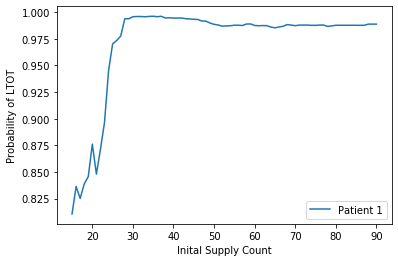

In [136]:
plt.plot(range(15, 91), new_predictions.iloc[-len(patient1_options):]['RF+LGB'].values, label = 'Patient 1')
plt.xlabel('Inital Supply Count')
plt.ylabel('Probability of LTOT')
plt.legend()
plt.show()

## Function to do this

In [190]:
def get_prediction_range(patient_features, sc_low, sc_high, step):
    
    patient_options = []
    
    for sc in range(sc_low, sc_high, step):
        df = change_inital(patient_features, sc)
        patient_options.append(df)
        
    patient_options = pd.concat(patient_options)
    
    new_model = Model(train_set=training_features, test_set=pd.concat([test_feat_fill, patient_options]))
    new_predictions = new_model.predict()
    
    return new_predictions.iloc[-len(patient_options):]

In [191]:
min_sc = 1
max_sc = 50

In [192]:
%%time
patient1_range = get_prediction_range(patient1, min_sc, max_sc, 1)
patient2_range = get_prediction_range(patient2, min_sc, max_sc, 1)
patient3_range = get_prediction_range(patient3, min_sc, max_sc, 1)

Wall time: 1min 19s


In [193]:
ranges = [patient1_range, patient2_range, patient3_range]

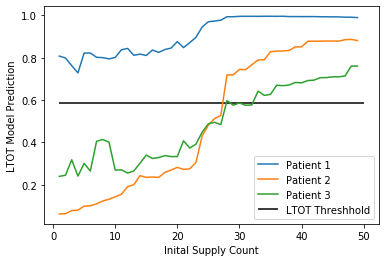

In [196]:
for count, patient in enumerate(ranges):
    plt.plot(range(min_sc, max_sc), patient['RF+LGB'].values, label = 'Patient ' + str(count+1))

plt.hlines(y=.586, xmin=min_sc, xmax=max_sc, label = "LTOT Threshhold")
plt.xlabel('Inital Supply Count')
plt.ylabel('LTOT Model Prediction')
plt.legend()
plt.show()